# Circle radius test
Learn the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ where $f:\bf{x} \mapsto |x|$ with a deep neural network and compute the mutual information changes between the input, the different layer outputs and the output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.spatial as ss
from scipy.special import digamma
from math import log

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_learning_curve(fitting_history):
    plt.clf()
    plt.figure(figsize=(10, 10))

    plt.subplot(2,1,1)
    plt.plot(fitting_history['loss'], color='steelblue')
    plt.plot(fitting_history['val_loss'], color='orange')
    plt.legend(['Training loss', 'Testing loss'])

    plt.subplot(2,1,2)
    plt.plot(fitting_history['acc'], color='steelblue')
    plt.plot(fitting_history['val_acc'], color='orange')
    plt.legend(['Training accuracy', 'Testing accuracy'])

    plt.show()

## Define function and generate random samples

In [3]:
def f(x):
    return np.where(np.sqrt(np.sum(x * x)) > 0.8, 1, 0)

In [4]:
dimensions = 2

np.random.seed(42)
X_train = np.random.uniform(-1, 1, size=[20000, dimensions])
Y_train = np.apply_along_axis(f, 1, X_train)

X_test = np.random.uniform(-1, 1, size=[1000, dimensions])
Y_test = np.apply_along_axis(f, 1, X_test)

In [5]:
pd.DataFrame(Y_train).describe()

,0
count,20000.000000
mean,0.492600
std,0.499958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Mutual information and entropy functions

In [132]:
def log_or_0(x):
    return np.log(x) if x > 0 else 0

np_log_or_0 = np.vectorize(log_or_0)

In [155]:
def entropy(x, k=3, base=2, seed=None):
    assert k < len(x)
    d, N = len(x[0]), len(x)
    
    if seed:
        np.random.seed(seed)
    intens = 1e-10
    small_noise_x = x + intens * np.random.rand(d)
    
    tree = ss.cKDTree(small_noise_x)
    nn = tree.query(small_noise_x, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]

    const = digamma(N) - digamma(k) + d * log(2)

    return (const + d * np.mean(np_log_or_0(nn))) / log(base)

In [156]:
def avg_digamma(points, dvec):
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    
    for i in range(N):
        dist = dvec[i]
        num_points = len(tree.query_ball_point(points[i], dist - 1e-15, p=float('inf')))
        avg += digamma(num_points) / N
        
    return avg

In [157]:
def mutual_information(x, y, k=3, base=2, seed=None):
    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    
    if seed:
        np.random.seed(seed)
    intens = 1e-6
    x_noise = x + intens * np.random.rand(len(x[0]))
    y_noise = y + intens * np.random.rand(len(y[0]))
    points = np.concatenate([x_noise, y_noise], axis=1)
                   
    tree = ss.cKDTree(points)
    dvec = tree.query(points, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]
       
    a, b, c, d = avg_digamma(x, dvec), avg_digamma(y, dvec), digamma(k), digamma(len(x))
    return (-a - b + c + d) / log(base)

In [158]:
def discrete_entropy(x):
    x_df = pd.DataFrame(x)
    probabilities = (x_df
        .reset_index()
        .groupby(list(x_df.columns))
        .count()) / x.shape[0]
    
    return - np.sum(probabilities * np.log2(probabilities))[0]

In [159]:
def mixed_mutual_information(x, y, k=3, base=2, seed=None):
    overallentropy = entropy(x, k, base, seed=seed)

    n = len(y)
    word_dict = dict()
    for i in range(len(y)):
        if type(y[i]) == list:
            y[i] = tuple(y[i])
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1. / n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        mi -= word_dict[yval] * entropy(xgiveny, k, base, seed=seed)
    return np.abs(mi)

## Callback which gathers mutual information during training

In [170]:
def output_of_nth_layer(n, x, model):
    intermediate_layer_model = Model(
        inputs=model.input,
        outputs=model.layers[n].output)
    return intermediate_layer_model.predict(x)

def all_layers_outputs(x, model):
    return [x] + [output_of_nth_layer(n, x, model) for n in range(len(model.layers))]

def get_mutual_information_X(x_0, layers_output, show_output=True):
    def compute_next(x):
        if show_output:
            print('Computing I(X, H_{})'.format(x[0]))
        return mutual_information(x_0, x[1])
    
    return list(map(compute_next, enumerate(layers_output)))

def get_mutual_information_Y(y_0, layers_output, k=None, show_output=True):
    def compute_next(x):
        if show_output:
            print('Computing I(H_{}, Y)'.format(x[0]))
        return mixed_mutual_information(x[1], y_0, k)
    
    return list(map(compute_next, enumerate(layers_output)))

In [174]:
class CollectMutualInformation(keras.callbacks.Callback):
    def __init__(self, period_in_epochs, x_test, y_test, y_k=None, show_output=True):
        self.period_in_epochs = period_in_epochs
        self.mutual_information_X = []
        self.mutual_information_Y = []
        self.x_test = x_test
        self.y_test = y_test
        self.y_k = y_k
        self.show_output = show_output
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.period_in_epochs == 0:
            layers_output = all_layers_outputs(self.x_test, self.model)
            self.mutual_information_X.append(
                get_mutual_information_X(self.x_test, layers_output, show_output=self.show_output))
            self.mutual_information_Y.append(
                get_mutual_information_Y(self.y_test, layers_output, k=self.y_k, show_output=self.show_output))

## Build a feed forward neural network

In [179]:
ffnn = Sequential([
    Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='sigmoid')
])

ffnn.compile(metrics=['accuracy'], optimizer=Adam(), loss='categorical_crossentropy')

In [180]:
%%time
number_of_epochs = 5000
batch_size = 1000
collectMutualInformation = CollectMutualInformation(10, X_test, Y_test, y_k=10, show_output=False)

ffnn_fitting = ffnn.fit(
    X_train, 
    to_categorical(Y_train),
    validation_data=(X_test, to_categorical(Y_test)),
    callbacks=[collectMutualInformation],
    epochs=number_of_epochs,
    batch_size=batch_size)

Train on 20000 samples, validate on 1000 samples
Epoch 1/5000
20000/20000 [==============================] - 2s 89us/step - loss: 0.6803 - acc: 0.5304 - val_loss: 0.6744 - val_acc: 0.5590
Epoch 2/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6753 - acc: 0.5664 - val_loss: 0.6684 - val_acc: 0.5900
Epoch 3/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6699 - acc: 0.5868 - val_loss: 0.6624 - val_acc: 0.5990
Epoch 4/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6643 - acc: 0.6039 - val_loss: 0.6557 - val_acc: 0.6080
Epoch 5/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6583 - acc: 0.6115 - val_loss: 0.6490 - val_acc: 0.6080
Epoch 6/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6519 - acc: 0.6144 - val_loss: 0.6420 - val_acc: 0.6190
Epoch 7/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6450 - acc: 0.6268 - val_loss: 0.6343 - 

20000/20000 [==============================] - 0s 3us/step - loss: 0.1603 - acc: 0.9831 - val_loss: 0.1565 - val_acc: 0.9820
Epoch 60/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.1577 - acc: 0.9838 - val_loss: 0.1536 - val_acc: 0.9820
Epoch 61/5000
20000/20000 [==============================] - 2s 84us/step - loss: 0.1549 - acc: 0.9838 - val_loss: 0.1511 - val_acc: 0.9840
Epoch 62/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.1523 - acc: 0.9843 - val_loss: 0.1488 - val_acc: 0.9820
Epoch 63/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1499 - acc: 0.9833 - val_loss: 0.1465 - val_acc: 0.9810
Epoch 64/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.1473 - acc: 0.9840 - val_loss: 0.1441 - val_acc: 0.9860
Epoch 65/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.1451 - acc: 0.9843 - val_loss: 0.1416 - val_acc: 0.9810
Epoch 66/5000
20000/20000 [=============

Epoch 118/5000
20000/20000 [==============================] - ETA: 0s - loss: 0.0739 - acc: 0.989 - 0s 3us/step - loss: 0.0738 - acc: 0.9898 - val_loss: 0.0705 - val_acc: 0.9910
Epoch 119/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0730 - acc: 0.9902 - val_loss: 0.0693 - val_acc: 0.9950
Epoch 120/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0723 - acc: 0.9897 - val_loss: 0.0687 - val_acc: 0.9930
Epoch 121/5000
20000/20000 [==============================] - 2s 82us/step - loss: 0.0714 - acc: 0.9896 - val_loss: 0.0680 - val_acc: 0.9930
Epoch 122/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0706 - acc: 0.9899 - val_loss: 0.0668 - val_acc: 0.9950
Epoch 123/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0702 - acc: 0.9899 - val_loss: 0.0664 - val_acc: 0.9930
Epoch 124/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0692 - acc: 0.9898 - val_loss: 0.0665

20000/20000 [==============================] - 0s 4us/step - loss: 0.0404 - acc: 0.9904 - val_loss: 0.0365 - val_acc: 0.9940
Epoch 177/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0395 - acc: 0.9904 - val_loss: 0.0353 - val_acc: 0.9940
Epoch 178/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0386 - acc: 0.9907 - val_loss: 0.0340 - val_acc: 0.9940
Epoch 179/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0380 - acc: 0.9912 - val_loss: 0.0350 - val_acc: 0.9920
Epoch 180/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0377 - acc: 0.9906 - val_loss: 0.0338 - val_acc: 0.9940
Epoch 181/5000
20000/20000 [==============================] - 2s 76us/step - loss: 0.0372 - acc: 0.9907 - val_loss: 0.0323 - val_acc: 0.9940
Epoch 182/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0364 - acc: 0.9910 - val_loss: 0.0329 - val_acc: 0.9920
Epoch 183/5000
20000/20000 [======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0245 - acc: 0.9911 - val_loss: 0.0193 - val_acc: 0.9950
Epoch 235/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0242 - acc: 0.9910 - val_loss: 0.0201 - val_acc: 0.9940
Epoch 236/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0239 - acc: 0.9918 - val_loss: 0.0191 - val_acc: 0.9940
Epoch 237/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0239 - acc: 0.9918 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 238/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0237 - acc: 0.9912 - val_loss: 0.0190 - val_acc: 0.9960
Epoch 239/5000
20000/20000 [==============================] - ETA: 0s - loss: 0.0231 - acc: 0.991 - 0s 3us/step - loss: 0.0236 - acc: 0.9915 - val_loss: 0.0192 - val_acc: 0.9940
Epoch 240/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0235 - acc: 0.9915 - val_loss: 0.0197 - val_acc: 0.99

20000/20000 [==============================] - 0s 4us/step - loss: 0.0205 - acc: 0.9922 - val_loss: 0.0168 - val_acc: 0.9950
Epoch 293/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0207 - acc: 0.9925 - val_loss: 0.0159 - val_acc: 0.9930
Epoch 294/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0203 - acc: 0.9921 - val_loss: 0.0162 - val_acc: 0.9940
Epoch 295/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0205 - acc: 0.9916 - val_loss: 0.0155 - val_acc: 0.9940
Epoch 296/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0205 - acc: 0.9919 - val_loss: 0.0155 - val_acc: 0.9950
Epoch 297/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0203 - acc: 0.9926 - val_loss: 0.0159 - val_acc: 0.9940
Epoch 298/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0203 - acc: 0.9924 - val_loss: 0.0156 - val_acc: 0.9940
Epoch 299/5000
20000/20000 [=======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0188 - acc: 0.9925 - val_loss: 0.0143 - val_acc: 0.9950
Epoch 351/5000
20000/20000 [==============================] - 1s 71us/step - loss: 0.0187 - acc: 0.9925 - val_loss: 0.0151 - val_acc: 0.9940
Epoch 352/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0190 - acc: 0.9926 - val_loss: 0.0164 - val_acc: 0.9950
Epoch 353/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0188 - acc: 0.9927 - val_loss: 0.0148 - val_acc: 0.9940
Epoch 354/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0185 - acc: 0.9927 - val_loss: 0.0140 - val_acc: 0.9950
Epoch 355/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0189 - acc: 0.9925 - val_loss: 0.0144 - val_acc: 0.9940
Epoch 356/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0186 - acc: 0.9928 - val_loss: 0.0144 - val_acc: 0.9940
Epoch 357/5000
20000/20000 [======

20000/20000 [==============================] - 0s 5us/step - loss: 0.0179 - acc: 0.9927 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 409/5000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0177 - acc: 0.9930 - val_loss: 0.0140 - val_acc: 0.9960
Epoch 410/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0179 - acc: 0.9931 - val_loss: 0.0130 - val_acc: 0.9940
Epoch 411/5000
20000/20000 [==============================] - 2s 81us/step - loss: 0.0178 - acc: 0.9924 - val_loss: 0.0130 - val_acc: 0.9940
Epoch 412/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0175 - acc: 0.9929 - val_loss: 0.0141 - val_acc: 0.9940
Epoch 413/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0177 - acc: 0.9929 - val_loss: 0.0134 - val_acc: 0.9940
Epoch 414/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0183 - acc: 0.9925 - val_loss: 0.0136 - val_acc: 0.9950
Epoch 415/5000
20000/20000 [======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0174 - acc: 0.9935 - val_loss: 0.0142 - val_acc: 0.9950
Epoch 467/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0174 - acc: 0.9930 - val_loss: 0.0122 - val_acc: 0.9940
Epoch 468/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0172 - acc: 0.9929 - val_loss: 0.0135 - val_acc: 0.9940
Epoch 469/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0169 - acc: 0.9932 - val_loss: 0.0141 - val_acc: 0.9940
Epoch 470/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0174 - acc: 0.9931 - val_loss: 0.0127 - val_acc: 0.9930
Epoch 471/5000
20000/20000 [==============================] - 1s 69us/step - loss: 0.0168 - acc: 0.9934 - val_loss: 0.0129 - val_acc: 0.9940
Epoch 472/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0167 - acc: 0.9935 - val_loss: 0.0130 - val_acc: 0.9940
Epoch 473/5000
20000/20000 [======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0162 - acc: 0.9934 - val_loss: 0.0116 - val_acc: 0.9930
Epoch 525/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0162 - acc: 0.9938 - val_loss: 0.0120 - val_acc: 0.9930
Epoch 526/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0159 - acc: 0.9936 - val_loss: 0.0120 - val_acc: 0.9950
Epoch 527/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0160 - acc: 0.9937 - val_loss: 0.0116 - val_acc: 0.9940
Epoch 528/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0163 - acc: 0.9934 - val_loss: 0.0120 - val_acc: 0.9940
Epoch 529/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0165 - acc: 0.9934 - val_loss: 0.0127 - val_acc: 0.9950
Epoch 530/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0164 - acc: 0.9932 - val_loss: 0.0120 - val_acc: 0.9940
Epoch 531/5000
20000/20000 [=======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0159 - acc: 0.9934 - val_loss: 0.0115 - val_acc: 0.9950
Epoch 583/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0160 - acc: 0.9944 - val_loss: 0.0121 - val_acc: 0.9950
Epoch 584/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0161 - acc: 0.9935 - val_loss: 0.0121 - val_acc: 0.9940
Epoch 585/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0165 - acc: 0.9930 - val_loss: 0.0115 - val_acc: 0.9940
Epoch 586/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0156 - acc: 0.9942 - val_loss: 0.0116 - val_acc: 0.9940
Epoch 587/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0160 - acc: 0.9932 - val_loss: 0.0123 - val_acc: 0.9940
Epoch 588/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0160 - acc: 0.9931 - val_loss: 0.0116 - val_acc: 0.9930
Epoch 589/5000
20000/20000 [=======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0161 - acc: 0.9933 - val_loss: 0.0117 - val_acc: 0.9950
Epoch 641/5000
20000/20000 [==============================] - 1s 68us/step - loss: 0.0154 - acc: 0.9937 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 642/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0152 - acc: 0.9937 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 643/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0153 - acc: 0.9938 - val_loss: 0.0113 - val_acc: 0.9960
Epoch 644/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0153 - acc: 0.9939 - val_loss: 0.0121 - val_acc: 0.9960
Epoch 645/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0152 - acc: 0.9937 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 646/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0153 - acc: 0.9940 - val_loss: 0.0115 - val_acc: 0.9950
Epoch 647/5000
20000/20000 [======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0151 - acc: 0.9938 - val_loss: 0.0111 - val_acc: 0.9950
Epoch 699/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0152 - acc: 0.9935 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 700/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0151 - acc: 0.9936 - val_loss: 0.0113 - val_acc: 0.9940
Epoch 701/5000
20000/20000 [==============================] - 2s 78us/step - loss: 0.0149 - acc: 0.9942 - val_loss: 0.0109 - val_acc: 0.9940
Epoch 702/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0149 - acc: 0.9943 - val_loss: 0.0113 - val_acc: 0.9940
Epoch 703/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0152 - acc: 0.9933 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 704/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0153 - acc: 0.9936 - val_loss: 0.0123 - val_acc: 0.9950
Epoch 705/5000
20000/20000 [======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0154 - acc: 0.9936 - val_loss: 0.0110 - val_acc: 0.9940
Epoch 757/5000
20000/20000 [==============================] - ETA: 0s - loss: 0.0145 - acc: 0.994 - 0s 3us/step - loss: 0.0148 - acc: 0.9938 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 758/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0150 - acc: 0.9936 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 759/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0147 - acc: 0.9939 - val_loss: 0.0107 - val_acc: 0.9940
Epoch 760/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0146 - acc: 0.9939 - val_loss: 0.0107 - val_acc: 0.9940
Epoch 761/5000
20000/20000 [==============================] - 1s 69us/step - loss: 0.0146 - acc: 0.9941 - val_loss: 0.0108 - val_acc: 0.9960
Epoch 762/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0147 - acc: 0.9939 - val_loss: 0.0106 - val_acc: 0.9

20000/20000 [==============================] - 0s 3us/step - loss: 0.0145 - acc: 0.9939 - val_loss: 0.0108 - val_acc: 0.9950
Epoch 815/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0144 - acc: 0.9944 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 816/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0146 - acc: 0.9942 - val_loss: 0.0107 - val_acc: 0.9940
Epoch 817/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0143 - acc: 0.9945 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 818/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0143 - acc: 0.9943 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 819/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0145 - acc: 0.9937 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 820/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0142 - acc: 0.9945 - val_loss: 0.0117 - val_acc: 0.9950
Epoch 821/5000
20000/20000 [=======

20000/20000 [==============================] - 0s 3us/step - loss: 0.0145 - acc: 0.9938 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 873/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0139 - acc: 0.9942 - val_loss: 0.0106 - val_acc: 0.9940
Epoch 874/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0141 - acc: 0.9945 - val_loss: 0.0101 - val_acc: 0.9940
Epoch 875/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0141 - acc: 0.9945 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 876/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0140 - acc: 0.9942 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 877/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0140 - acc: 0.9945 - val_loss: 0.0122 - val_acc: 0.9960
Epoch 878/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0144 - acc: 0.9941 - val_loss: 0.0116 - val_acc: 0.9950
Epoch 879/5000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0150 - acc: 0.9938 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 931/5000
20000/20000 [==============================] - 2s 90us/step - loss: 0.0149 - acc: 0.9941 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 932/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0143 - acc: 0.9943 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 933/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0137 - acc: 0.9947 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 934/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0138 - acc: 0.9940 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 935/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0137 - acc: 0.9945 - val_loss: 0.0101 - val_acc: 0.9940
Epoch 936/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0139 - acc: 0.9946 - val_loss: 0.0108 - val_acc: 0.9960
Epoch 937/5000
20000/20000 [======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0139 - acc: 0.9947 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 989/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0140 - acc: 0.9946 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 990/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0137 - acc: 0.9943 - val_loss: 0.0102 - val_acc: 0.9940
Epoch 991/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0136 - acc: 0.9944 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 992/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0142 - acc: 0.9944 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 993/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0136 - acc: 0.9945 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 994/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0143 - acc: 0.9942 - val_loss: 0.0097 - val_acc: 0.9940
Epoch 995/5000
20000/20000 [======

Epoch 1046/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0137 - acc: 0.9946 - val_loss: 0.0099 - val_acc: 0.9940
Epoch 1047/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0136 - acc: 0.9944 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 1048/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0144 - acc: 0.9941 - val_loss: 0.0098 - val_acc: 0.9940
Epoch 1049/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0141 - acc: 0.9944 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 1050/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0137 - acc: 0.9947 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 1051/5000
20000/20000 [==============================] - 1s 72us/step - loss: 0.0134 - acc: 0.9949 - val_loss: 0.0109 - val_acc: 0.9960
Epoch 1052/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0138 - acc: 0.9944 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 1053/5

20000/20000 [==============================] - 0s 4us/step - loss: 0.0135 - acc: 0.9949 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 1105/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0133 - acc: 0.9951 - val_loss: 0.0100 - val_acc: 0.9940
Epoch 1106/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9945 - val_loss: 0.0109 - val_acc: 0.9960
Epoch 1107/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9949 - val_loss: 0.0100 - val_acc: 0.9940
Epoch 1108/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0136 - acc: 0.9946 - val_loss: 0.0102 - val_acc: 0.9940
Epoch 1109/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0135 - acc: 0.9946 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 1110/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0135 - acc: 0.9947 - val_loss: 0.0095 - val_acc: 0.9940
Epoch 1111/5000
20000/20000 [

20000/20000 [==============================] - 0s 5us/step - loss: 0.0138 - acc: 0.9947 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 1163/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0135 - acc: 0.9948 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 1164/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0136 - acc: 0.9942 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 1165/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0141 - acc: 0.9940 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 1166/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0144 - acc: 0.9944 - val_loss: 0.0101 - val_acc: 0.9940
Epoch 1167/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0135 - acc: 0.9942 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1168/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9950 - val_loss: 0.0098 - val_acc: 0.9940
Epoch 1169/5000
20000/20000 [

20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9944 - val_loss: 0.0101 - val_acc: 0.9940
Epoch 1221/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0133 - acc: 0.9948 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 1222/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9947 - val_loss: 0.0105 - val_acc: 0.9940
Epoch 1223/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9949 - val_loss: 0.0106 - val_acc: 0.9960
Epoch 1224/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9948 - val_loss: 0.0100 - val_acc: 0.9940
Epoch 1225/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0137 - acc: 0.9945 - val_loss: 0.0095 - val_acc: 0.9950
Epoch 1226/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0134 - acc: 0.9949 - val_loss: 0.0102 - val_acc: 0.9960
Epoch 1227/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0135 - acc: 0.9945 - val_loss: 0.0113 - val_acc: 0.9960
Epoch 1279/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9953 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 1280/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9944 - val_loss: 0.0097 - val_acc: 0.9930
Epoch 1281/5000
20000/20000 [==============================] - 2s 76us/step - loss: 0.0131 - acc: 0.9951 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 1282/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9946 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 1283/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9948 - val_loss: 0.0092 - val_acc: 0.9950
Epoch 1284/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9949 - val_loss: 0.0102 - val_acc: 0.9960
Epoch 1285/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0128 - acc: 0.9949 - val_loss: 0.0115 - val_acc: 0.9960
Epoch 1337/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0133 - acc: 0.9949 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 1338/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0129 - acc: 0.9952 - val_loss: 0.0093 - val_acc: 0.9940
Epoch 1339/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9952 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1340/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9948 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 1341/5000
20000/20000 [==============================] - 1s 72us/step - loss: 0.0128 - acc: 0.9951 - val_loss: 0.0094 - val_acc: 0.9940
Epoch 1342/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0126 - acc: 0.9950 - val_loss: 0.0097 - val_acc: 0.9940
Epoch 1343/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0128 - acc: 0.9952 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 1395/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0125 - acc: 0.9949 - val_loss: 0.0091 - val_acc: 0.9940
Epoch 1396/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0127 - acc: 0.9952 - val_loss: 0.0101 - val_acc: 0.9940
Epoch 1397/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0127 - acc: 0.9950 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 1398/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0128 - acc: 0.9954 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 1399/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0128 - acc: 0.9952 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 1400/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0126 - acc: 0.9949 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 1401/5000
20000/20000 [

20000/20000 [==============================] - 0s 3us/step - loss: 0.0123 - acc: 0.9947 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 1453/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0130 - acc: 0.9948 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 1454/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0124 - acc: 0.9947 - val_loss: 0.0106 - val_acc: 0.9960
Epoch 1455/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0129 - acc: 0.9947 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1456/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0125 - acc: 0.9951 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 1457/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0124 - acc: 0.9950 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 1458/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0122 - acc: 0.9952 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 1459/5000
20000/20000 [

20000/20000 [==============================] - 0s 2us/step - loss: 0.0123 - acc: 0.9955 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 1511/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0123 - acc: 0.9950 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 1512/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0122 - acc: 0.9951 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 1513/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0124 - acc: 0.9949 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 1514/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0123 - acc: 0.9947 - val_loss: 0.0093 - val_acc: 0.9950
Epoch 1515/5000
20000/20000 [==============================] - 0s 2us/step - loss: 0.0124 - acc: 0.9948 - val_loss: 0.0092 - val_acc: 0.9950
Epoch 1516/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0125 - acc: 0.9948 - val_loss: 0.0091 - val_acc: 0.9950
Epoch 1517/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0118 - acc: 0.9951 - val_loss: 0.0090 - val_acc: 0.9950
Epoch 1569/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0122 - acc: 0.9952 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 1570/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0121 - acc: 0.9953 - val_loss: 0.0111 - val_acc: 0.9940
Epoch 1571/5000
20000/20000 [==============================] - 1s 72us/step - loss: 0.0122 - acc: 0.9949 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 1572/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0120 - acc: 0.9957 - val_loss: 0.0093 - val_acc: 0.9950
Epoch 1573/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0127 - acc: 0.9948 - val_loss: 0.0094 - val_acc: 0.9950
Epoch 1574/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0119 - acc: 0.9954 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1575/5000
20000/20000 

Epoch 1626/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0120 - acc: 0.9953 - val_loss: 0.0090 - val_acc: 0.9950
Epoch 1627/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0118 - acc: 0.9954 - val_loss: 0.0090 - val_acc: 0.9950
Epoch 1628/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0121 - acc: 0.9952 - val_loss: 0.0116 - val_acc: 0.9940
Epoch 1629/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0126 - acc: 0.9951 - val_loss: 0.0140 - val_acc: 0.9960
Epoch 1630/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0124 - acc: 0.9949 - val_loss: 0.0118 - val_acc: 0.9960
Epoch 1631/5000
20000/20000 [==============================] - 2s 76us/step - loss: 0.0123 - acc: 0.9950 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 1632/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0117 - acc: 0.9953 - val_loss: 0.0098 - val_acc: 0.9940
Epoch 1633/5

20000/20000 [==============================] - 0s 4us/step - loss: 0.0120 - acc: 0.9953 - val_loss: 0.0094 - val_acc: 0.9950
Epoch 1685/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0118 - acc: 0.9951 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 1686/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0119 - acc: 0.9949 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 1687/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0114 - acc: 0.9956 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 1688/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0117 - acc: 0.9953 - val_loss: 0.0107 - val_acc: 0.9940
Epoch 1689/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0123 - acc: 0.9948 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 1690/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0117 - acc: 0.9952 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 1691/5000
20000/20000 [

20000/20000 [==============================] - 0s 3us/step - loss: 0.0117 - acc: 0.9954 - val_loss: 0.0116 - val_acc: 0.9940
Epoch 1743/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0115 - acc: 0.9951 - val_loss: 0.0086 - val_acc: 0.9950
Epoch 1744/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9955 - val_loss: 0.0099 - val_acc: 0.9940
Epoch 1745/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0113 - acc: 0.9957 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 1746/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0114 - acc: 0.9956 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 1747/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0116 - acc: 0.9954 - val_loss: 0.0092 - val_acc: 0.9950
Epoch 1748/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0113 - acc: 0.9954 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 1749/5000
20000/20000 [

20000/20000 [==============================] - 0s 3us/step - loss: 0.0110 - acc: 0.9958 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 1801/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0110 - acc: 0.9960 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 1802/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0109 - acc: 0.9957 - val_loss: 0.0112 - val_acc: 0.9950
Epoch 1803/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9953 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 1804/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0109 - acc: 0.9954 - val_loss: 0.0113 - val_acc: 0.9940
Epoch 1805/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0108 - acc: 0.9956 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 1806/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0110 - acc: 0.9955 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 1807/5000
20000/20000 

Epoch 1858/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0119 - acc: 0.9949 - val_loss: 0.0118 - val_acc: 0.9960
Epoch 1859/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0111 - acc: 0.9955 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 1860/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0111 - acc: 0.9956 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 1861/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0108 - acc: 0.9961 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 1862/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9961 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 1863/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0112 - acc: 0.9957 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 1864/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9956 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 1865/5

20000/20000 [==============================] - 0s 3us/step - loss: 0.0117 - acc: 0.9953 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 1917/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0111 - acc: 0.9954 - val_loss: 0.0117 - val_acc: 0.9960
Epoch 1918/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 1919/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0109 - acc: 0.9959 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 1920/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9958 - val_loss: 0.0091 - val_acc: 0.9950
Epoch 1921/5000
20000/20000 [==============================] - 2s 79us/step - loss: 0.0108 - acc: 0.9958 - val_loss: 0.0096 - val_acc: 0.9940
Epoch 1922/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0110 - acc: 0.9957 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 1923/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 1975/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9958 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1976/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9957 - val_loss: 0.0121 - val_acc: 0.9950
Epoch 1977/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0109 - acc: 0.9953 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 1978/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9959 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 1979/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 1980/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9959 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 1981/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9956 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 2033/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9960 - val_loss: 0.0118 - val_acc: 0.9950
Epoch 2034/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0110 - acc: 0.9958 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 2035/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2036/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 2037/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9962 - val_loss: 0.0092 - val_acc: 0.9940
Epoch 2038/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0114 - acc: 0.9955 - val_loss: 0.0111 - val_acc: 0.9950
Epoch 2039/5000
20000/20000 [

Epoch 2090/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0114 - acc: 0.9954 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 2091/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0108 - acc: 0.9959 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 2092/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9959 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 2093/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9957 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 2094/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9960 - val_loss: 0.0111 - val_acc: 0.9940
Epoch 2095/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9956 - val_loss: 0.0112 - val_acc: 0.9960
Epoch 2096/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0109 - acc: 0.9957 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 2097/5

20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9959 - val_loss: 0.0114 - val_acc: 0.9950
Epoch 2149/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0117 - acc: 0.9951 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2150/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0092 - val_acc: 0.9940
Epoch 2151/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0110 - acc: 0.9956 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 2152/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9961 - val_loss: 0.0087 - val_acc: 0.9970
Epoch 2153/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 2154/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0109 - acc: 0.9954 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 2155/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 2207/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9959 - val_loss: 0.0114 - val_acc: 0.9950
Epoch 2208/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9957 - val_loss: 0.0155 - val_acc: 0.9950
Epoch 2209/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9951 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 2210/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0111 - acc: 0.9958 - val_loss: 0.0086 - val_acc: 0.9960
Epoch 2211/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2212/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9961 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 2213/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9950
Epoch 2265/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9957 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 2266/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0110 - acc: 0.9956 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 2267/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 2268/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0106 - acc: 0.9961 - val_loss: 0.0094 - val_acc: 0.9950
Epoch 2269/5000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0101 - acc: 0.9963 - val_loss: 0.0098 - val_acc: 0.9970
Epoch 2270/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9963 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 2271/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9955 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 2323/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9963 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 2324/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 2325/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9962 - val_loss: 0.0092 - val_acc: 0.9950
Epoch 2326/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0090 - val_acc: 0.9960
Epoch 2327/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9964 - val_loss: 0.0103 - val_acc: 0.9960
Epoch 2328/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0091 - val_acc: 0.9950
Epoch 2329/5000
20000/20000 [

Epoch 2380/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0091 - val_acc: 0.9940
Epoch 2381/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0085 - val_acc: 0.9970
Epoch 2382/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 2383/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9958 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 2384/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0103 - val_acc: 0.9960
Epoch 2385/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 2386/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9959 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 2387/5

20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0095 - val_acc: 0.9950
Epoch 2439/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9957 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 2440/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 2441/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0104 - acc: 0.9958 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2442/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 2443/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9962 - val_loss: 0.0105 - val_acc: 0.9960
Epoch 2444/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0108 - acc: 0.9957 - val_loss: 0.0125 - val_acc: 0.9960
Epoch 2445/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9962 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 2497/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9963 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 2498/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9963 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 2499/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0090 - val_acc: 0.9960
Epoch 2500/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9961 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2501/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2502/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0090 - val_acc: 0.9970
Epoch 2503/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0108 - acc: 0.9955 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 2555/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 2556/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 2557/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 2558/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9961 - val_loss: 0.0093 - val_acc: 0.9950
Epoch 2559/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9954 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2560/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9957 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 2561/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9940
Epoch 2613/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 2614/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9958 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 2615/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9956 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 2616/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 2617/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 2618/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.0086 - val_acc: 0.9960
Epoch 2619/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 2671/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0102 - acc: 0.9956 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 2672/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9956 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 2673/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9961 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 2674/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9959 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 2675/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9959 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 2676/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0095 - val_acc: 0.9940
Epoch 2677/5000
20000/20000 

20000/20000 [==============================] - 0s 5us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0108 - val_acc: 0.9950
Epoch 2729/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 2730/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 2731/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0111 - acc: 0.9953 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 2732/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9955 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 2733/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9964 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 2734/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0087 - val_acc: 0.9960
Epoch 2735/5000
20000/20000 

Epoch 2786/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 2787/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9963 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 2788/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9962 - val_loss: 0.0109 - val_acc: 0.9940
Epoch 2789/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9964 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 2790/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0112 - val_acc: 0.9950
Epoch 2791/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 2792/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2793/5

20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0114 - val_acc: 0.9950
Epoch 2845/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0090 - val_acc: 0.9960
Epoch 2846/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9963 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 2847/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9961 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 2848/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9956 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 2849/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9970
Epoch 2850/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9961 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 2851/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9959 - val_loss: 0.0115 - val_acc: 0.9950
Epoch 2903/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0086 - val_acc: 0.9960
Epoch 2904/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9959 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2905/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9961 - val_loss: 0.0091 - val_acc: 0.9950
Epoch 2906/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9956 - val_loss: 0.0104 - val_acc: 0.9940
Epoch 2907/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2908/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0090 - val_acc: 0.9960
Epoch 2909/5000
20000/20000 [

20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 2961/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0108 - acc: 0.9955 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 2962/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9958 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 2963/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0086 - val_acc: 0.9960
Epoch 2964/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9953 - val_loss: 0.0117 - val_acc: 0.9960
Epoch 2965/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9953 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 2966/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 2967/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9957 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 3019/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9957 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 3020/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9965 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 3021/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0114 - val_acc: 0.9950
Epoch 3022/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 3023/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 3024/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9954 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 3025/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 3077/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0090 - val_acc: 0.9970
Epoch 3078/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9958 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3079/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0108 - acc: 0.9956 - val_loss: 0.0143 - val_acc: 0.9950
Epoch 3080/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 3081/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 3082/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 3083/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 3135/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9955 - val_loss: 0.0117 - val_acc: 0.9950
Epoch 3136/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 3137/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 3138/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0112 - val_acc: 0.9950
Epoch 3139/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9958 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 3140/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9958 - val_loss: 0.0086 - val_acc: 0.9950
Epoch 3141/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0110 - acc: 0.9957 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 3193/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.0094 - val_acc: 0.9970
Epoch 3194/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3195/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9957 - val_loss: 0.0115 - val_acc: 0.9950
Epoch 3196/5000
20000/20000 [==============================] - ETA: 0s - loss: 0.0102 - acc: 0.996 - 0s 4us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 3197/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3198/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0133 - val_acc

20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0138 - val_acc: 0.9960
Epoch 3250/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3251/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 3252/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 3253/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 3254/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9963 - val_loss: 0.0099 - val_acc: 0.9930
Epoch 3255/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0110 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3256/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9956 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 3308/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3309/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0100 - val_acc: 0.9970
Epoch 3310/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 3311/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0115 - acc: 0.9954 - val_loss: 0.0117 - val_acc: 0.9950
Epoch 3312/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9960 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3313/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9957 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3314/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9958 - val_loss: 0.0088 - val_acc: 0.9950
Epoch 3366/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 3367/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 3368/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9964 - val_loss: 0.0096 - val_acc: 0.9970
Epoch 3369/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 3370/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 3371/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0104 - acc: 0.9961 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3372/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0108 - val_acc: 0.9960
Epoch 3424/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9955 - val_loss: 0.0095 - val_acc: 0.9970
Epoch 3425/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0104 - val_acc: 0.9960
Epoch 3426/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0093 - val_acc: 0.9970
Epoch 3427/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9963 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 3428/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0109 - acc: 0.9957 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 3429/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0096 - acc: 0.9961 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 3430/5000
20000/20000 [

Epoch 3481/5000
20000/20000 [==============================] - 1s 73us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 3482/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 3483/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3484/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9963 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3485/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9960 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3486/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 3487/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0085 - val_acc: 0.9950
Epoch 3488/5

20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9956 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 3540/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9963 - val_loss: 0.0123 - val_acc: 0.9950
Epoch 3541/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0104 - acc: 0.9957 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 3542/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0107 - acc: 0.9955 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 3543/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 3544/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0116 - val_acc: 0.9950
Epoch 3545/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9958 - val_loss: 0.0115 - val_acc: 0.9950
Epoch 3546/5000
20000/20000 

Epoch 3597/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9963 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 3598/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 3599/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3600/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3601/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 3602/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0100 - val_acc: 0.9950
Epoch 3603/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9959 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 3604/5

20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0095 - val_acc: 0.9970
Epoch 3656/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 3657/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9955 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 3658/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9961 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 3659/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0112 - val_acc: 0.9950
Epoch 3660/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9955 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 3661/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3662/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0095 - acc: 0.9963 - val_loss: 0.0117 - val_acc: 0.9960
Epoch 3714/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9959 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 3715/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9960 - val_loss: 0.0103 - val_acc: 0.9960
Epoch 3716/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 3717/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9961 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3718/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 3719/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9958 - val_loss: 0.0093 - val_acc: 0.9950
Epoch 3720/5000
20000/20000 [

20000/20000 [==============================] - 1s 74us/step - loss: 0.0096 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 3772/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9957 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 3773/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0097 - acc: 0.9961 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 3774/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0109 - acc: 0.9951 - val_loss: 0.0111 - val_acc: 0.9950
Epoch 3775/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9961 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3776/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9959 - val_loss: 0.0114 - val_acc: 0.9940
Epoch 3777/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 3778/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3829/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9956 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 3830/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9963 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 3831/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3832/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.0108 - val_acc: 0.9950
Epoch 3833/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 3834/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 3835/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9957 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 3887/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9956 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 3888/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 3889/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 3890/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 3891/5000
20000/20000 [==============================] - 1s 74us/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 3892/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9970
Epoch 3893/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0097 - acc: 0.9959 - val_loss: 0.0094 - val_acc: 0.9950
Epoch 3945/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9950
Epoch 3946/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 3947/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 3948/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9955 - val_loss: 0.0104 - val_acc: 0.9960
Epoch 3949/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9963 - val_loss: 0.0103 - val_acc: 0.9940
Epoch 3950/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0112 - val_acc: 0.9940
Epoch 3951/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9963 - val_loss: 0.0118 - val_acc: 0.9950
Epoch 4003/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9961 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 4004/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0097 - acc: 0.9958 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 4005/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9961 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4006/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 4007/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4008/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 4009/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 4061/5000
20000/20000 [==============================] - 1s 75us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 4062/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9960 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 4063/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4064/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 4065/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9961 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 4066/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4067/5000
20000/20000 

Epoch 4118/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0129 - val_acc: 0.9950
Epoch 4119/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0107 - val_acc: 0.9950
Epoch 4120/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9959 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4121/5000
20000/20000 [==============================] - 1s 75us/step - loss: 0.0097 - acc: 0.9961 - val_loss: 0.0116 - val_acc: 0.9950
Epoch 4122/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 4123/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9961 - val_loss: 0.0099 - val_acc: 0.9970
Epoch 4124/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 4125/5

20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0108 - val_acc: 0.9950
Epoch 4177/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9955 - val_loss: 0.0122 - val_acc: 0.9950
Epoch 4178/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 4179/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9957 - val_loss: 0.0091 - val_acc: 0.9970
Epoch 4180/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 4181/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0102 - acc: 0.9959 - val_loss: 0.0125 - val_acc: 0.9950
Epoch 4182/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0125 - val_acc: 0.9950
Epoch 4183/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9957 - val_loss: 0.0122 - val_acc: 0.9950
Epoch 4235/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9956 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 4236/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9961 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 4237/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0126 - val_acc: 0.9950
Epoch 4238/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0133 - val_acc: 0.9950
Epoch 4239/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9956 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 4240/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 4241/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4293/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0096 - acc: 0.9959 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 4294/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0094 - acc: 0.9958 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 4295/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9958 - val_loss: 0.0099 - val_acc: 0.9950
Epoch 4296/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9958 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4297/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9963 - val_loss: 0.0108 - val_acc: 0.9940
Epoch 4298/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 4299/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0096 - acc: 0.9959 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4351/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0100 - val_acc: 0.9970
Epoch 4352/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9958 - val_loss: 0.0114 - val_acc: 0.9940
Epoch 4353/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9960 - val_loss: 0.0104 - val_acc: 0.9960
Epoch 4354/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9954 - val_loss: 0.0153 - val_acc: 0.9960
Epoch 4355/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0112 - acc: 0.9953 - val_loss: 0.0116 - val_acc: 0.9950
Epoch 4356/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0110 - acc: 0.9952 - val_loss: 0.0125 - val_acc: 0.9930
Epoch 4357/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 4409/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9957 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 4410/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4411/5000
20000/20000 [==============================] - 2s 77us/step - loss: 0.0096 - acc: 0.9962 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 4412/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0121 - val_acc: 0.9950
Epoch 4413/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 4414/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9957 - val_loss: 0.0120 - val_acc: 0.9950
Epoch 4415/5000
20000/20000 

20000/20000 [==============================] - 0s 3us/step - loss: 0.0097 - acc: 0.9959 - val_loss: 0.0094 - val_acc: 0.9970
Epoch 4467/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9958 - val_loss: 0.0099 - val_acc: 0.9970
Epoch 4468/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 4469/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9956 - val_loss: 0.0083 - val_acc: 0.9960
Epoch 4470/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9959 - val_loss: 0.0087 - val_acc: 0.9960
Epoch 4471/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0106 - acc: 0.9957 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 4472/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0096 - acc: 0.9962 - val_loss: 0.0109 - val_acc: 0.9940
Epoch 4473/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0096 - val_acc: 0.9950
Epoch 4525/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0106 - acc: 0.9954 - val_loss: 0.0091 - val_acc: 0.9960
Epoch 4526/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4527/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9958 - val_loss: 0.0099 - val_acc: 0.9930
Epoch 4528/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0106 - acc: 0.9961 - val_loss: 0.0097 - val_acc: 0.9950
Epoch 4529/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 4530/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9958 - val_loss: 0.0102 - val_acc: 0.9960
Epoch 4531/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9958 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 4583/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9960 - val_loss: 0.0122 - val_acc: 0.9950
Epoch 4584/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0111 - acc: 0.9952 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 4585/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9955 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 4586/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 4587/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0093 - val_acc: 0.9960
Epoch 4588/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9957 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4589/5000
20000/20000 [

20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0087 - val_acc: 0.9960
Epoch 4641/5000
20000/20000 [==============================] - 2s 76us/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 4642/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0143 - val_acc: 0.9960
Epoch 4643/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0103 - acc: 0.9958 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4644/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0097 - acc: 0.9961 - val_loss: 0.0108 - val_acc: 0.9950
Epoch 4645/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9960 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 4646/5000
20000/20000 [==============================] - ETA: 0s - loss: 0.0101 - acc: 0.996 - 0s 3us/step - loss: 0.0102 - acc: 0.9959 - val_loss: 0.0116 - val_ac

20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9959 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 4698/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9957 - val_loss: 0.0118 - val_acc: 0.9950
Epoch 4699/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0101 - val_acc: 0.9960
Epoch 4700/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9962 - val_loss: 0.0099 - val_acc: 0.9960
Epoch 4701/5000
20000/20000 [==============================] - 2s 77us/step - loss: 0.0102 - acc: 0.9959 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 4702/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9964 - val_loss: 0.0102 - val_acc: 0.9950
Epoch 4703/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0096 - acc: 0.9961 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 4704/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9957 - val_loss: 0.0113 - val_acc: 0.9950
Epoch 4756/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0115 - acc: 0.9958 - val_loss: 0.0097 - val_acc: 0.9930
Epoch 4757/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 4758/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9961 - val_loss: 0.0092 - val_acc: 0.9950
Epoch 4759/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0111 - val_acc: 0.9940
Epoch 4760/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9961 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4761/5000
20000/20000 [==============================] - 2s 76us/step - loss: 0.0101 - acc: 0.9964 - val_loss: 0.0111 - val_acc: 0.9950
Epoch 4762/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0088 - val_acc: 0.9960
Epoch 4814/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0110 - val_acc: 0.9950
Epoch 4815/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 4816/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0101 - acc: 0.9960 - val_loss: 0.0106 - val_acc: 0.9950
Epoch 4817/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0102 - acc: 0.9956 - val_loss: 0.0094 - val_acc: 0.9960
Epoch 4818/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 4819/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0097 - val_acc: 0.9960
Epoch 4820/5000
20000/20000 [

20000/20000 [==============================] - 2s 76us/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 4872/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0096 - val_acc: 0.9960
Epoch 4873/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9958 - val_loss: 0.0087 - val_acc: 0.9950
Epoch 4874/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9964 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4875/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0100 - acc: 0.9956 - val_loss: 0.0089 - val_acc: 0.9960
Epoch 4876/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0085 - val_acc: 0.9950
Epoch 4877/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0096 - acc: 0.9964 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 4878/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9956 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 4930/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4931/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0100 - acc: 0.9958 - val_loss: 0.0131 - val_acc: 0.9950
Epoch 4932/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0099 - acc: 0.9959 - val_loss: 0.0112 - val_acc: 0.9950
Epoch 4933/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 0.0125 - val_acc: 0.9960
Epoch 4934/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0102 - acc: 0.9956 - val_loss: 0.0103 - val_acc: 0.9950
Epoch 4935/5000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9955 - val_loss: 0.0121 - val_acc: 0.9950
Epoch 4936/5000
20000/20000 

20000/20000 [==============================] - 0s 4us/step - loss: 0.0104 - acc: 0.9961 - val_loss: 0.0102 - val_acc: 0.9940
Epoch 4988/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0104 - acc: 0.9960 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 4989/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0095 - acc: 0.9959 - val_loss: 0.0104 - val_acc: 0.9950
Epoch 4990/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0099 - acc: 0.9957 - val_loss: 0.0085 - val_acc: 0.9950
Epoch 4991/5000
20000/20000 [==============================] - 2s 75us/step - loss: 0.0102 - acc: 0.9954 - val_loss: 0.0098 - val_acc: 0.9970
Epoch 4992/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0095 - acc: 0.9959 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 4993/5000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0098 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9960
Epoch 4994/5000
20000/20000 

In [181]:
print('Test accuracy: {}'.format(ffnn.evaluate(X_test, to_categorical(Y_test))[1]))

1000/1000 [==============================] - 0s 46us/step
Test accuracy: 0.996


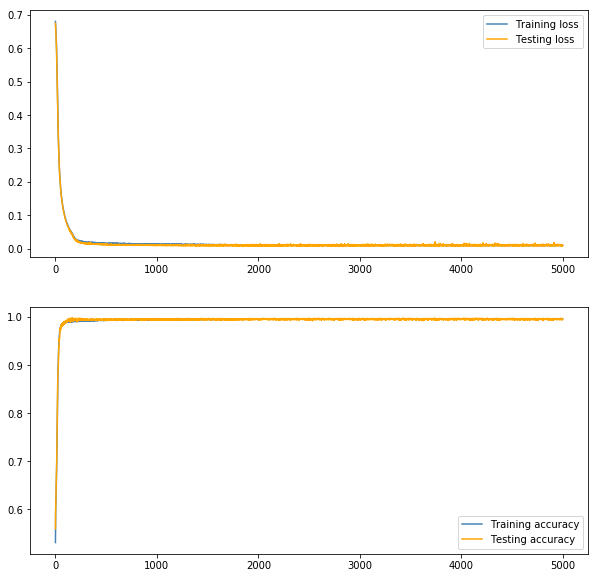

In [182]:
plot_learning_curve(ffnn_fitting.history)

In [248]:
from matplotlib.patches import Wedge

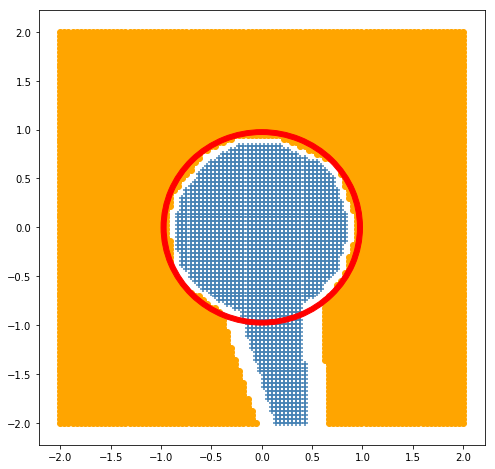

In [268]:
grid = np.mgrid[-2:2:100j, -2:2:100j]
samples = np.concatenate(list(np.stack(grid.T, axis=1)), axis=0)
predictions = ffnn.predict(samples)[:, 1]

samples_0 = samples[predictions < 0.1]
samples_1 = samples[predictions == 1]

plt.clf()

fig, ax = plt.subplots()
fig.set_size_inches((8, 8))
ax.add_patch(Wedge((0, 0), 1, 0, 360, width=0.05, color='red'))
plt.scatter(samples_0[:, 0], samples_0[:,1], c='steelblue',  marker='+')
plt.scatter(samples_1[:, 0], samples_1[:, 1], c='orange', marker='o')

plt.show()

## Mutual information through time

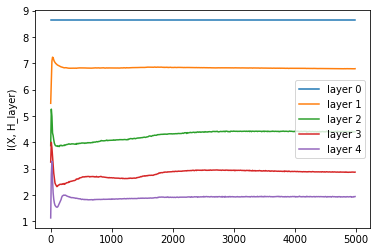

In [269]:
lines = []
for i, layer in enumerate(list(np.array(collectMutualInformation.mutual_information_X).T)):
    line, = plt.plot(np.arange(len(layer)) * 10, layer, label='layer {}'.format(i))
    lines.append(line)
    
plt.legend(handles=lines)
plt.ylabel('I(X, H_layer)')
plt.xlabel = 'Epochs'
plt.show()

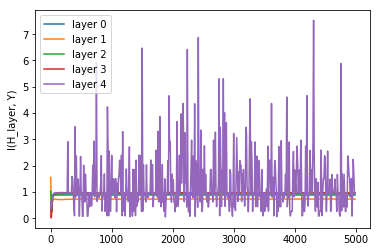

In [270]:
lines = []
for i, layer in enumerate(list(np.array(collectMutualInformation.mutual_information_Y).T)):
    line, = plt.plot(np.arange(len(layer)) * 10, layer, label='layer {}'.format(i))
    lines.append(line)
    
plt.legend(handles=lines)
plt.ylabel('I(H_layer, Y)')
plt.xlabel = 'Epochs'
plt.show()